# Week 4 - Probability Distributions 3 and Mixture Models

### Jonas Lund, 201906201, 27/09/2022

Learning contents:

1. Histogram-based density estimation
    - Display histogram densities
2. Kernel density estimation
    - Hypercube Kernel function
    - Gaussian Kernel function
3. K-Nearest Neigbours classification
    - Generate data
    - Classification function
    - Display results
4. K-Means clustering
    - Display results

## Dependencies

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt
from collections import Counter
from scipy.stats import norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate data

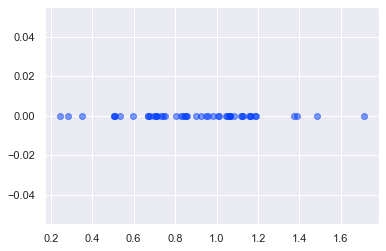

In [205]:
def generate_data_1D(size, means, variances, pis):
    result = 0
    
    for i, (mean, variance, pi) in enumerate(zip(means, variances, pis)):
        result += pi * np.array(norm(mean, sqrt(variance)).rvs(size=size, random_state=26 + i))
    
    return result
    
means = [0.4, 2.0]
variances = [0.2, 0.1]
pis = [0.7, 0.3]
data_1D = generate_data_1D(50, means, variances, pis)

plt.scatter(data_1D, [0] * len(data_1D), alpha=0.5)

## 1) Histogram-based density estimation

`histogram` takes `data`, bin size `delta` and returns `bins` (list of bins where `bin = list of points`) and their `probabilities`

In [206]:
def histogram(data, delta):
    data = sorted(data)
    bin_start = data[0]
    bin_end = data[0] + delta
    bins = []

    while bin_start < data[-1]:
        bins.append([
            data_point
            for data_point in data if data_point < bin_end and data_point >= bin_start
        ])
        bin_start += delta
        bin_end += delta
    
    probabilities = [
        len(bin_) / (len(data) * delta)
        for bin_ in bins
    ]
    
    return bins, probabilities

### 1.1) Display histogram densities

In [207]:
def display_histogram_density(data, delta):
    bins, probabilities = histogram(data, delta)

    plt.bar(range(len(bins)), list(map(lambda b: len(b), bins)))
    plt.plot(range(len(probabilities)), probabilities, '-r')


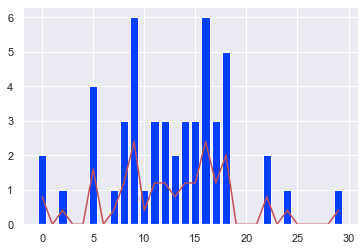

In [208]:
display_histogram_density(data_1D, 0.05)

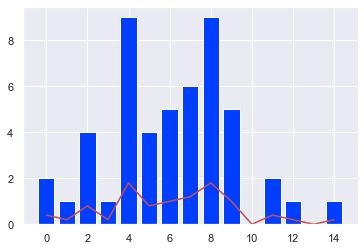

In [209]:
display_histogram_density(data_1D, 0.1)

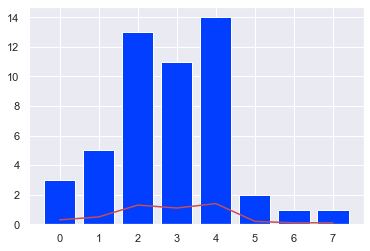

In [210]:
display_histogram_density(data_1D, 0.2)

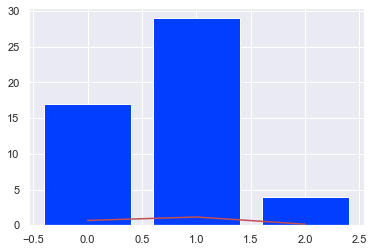

In [211]:
display_histogram_density(data_1D, 0.5)

## 2) Kernel density estimation

### 2.1) Hypercube Kernel function

`hypercube_kernel_function` takes `u` and returns 0 or 1 if `u` is inside 1/2 hypercube

In [212]:
def hypercube_kernel_function(u):
    result = 1 if abs(u) <= 0.5 else 0
    return result

`hypercube_kernel_density` takes any point `x`, data points `data`, size of a cube `h`, amount of dimensions `D` and returns probability density function based on Hypercube kernel function

In [213]:
def hypercube_kernel_density(x, data, h, D):
    result = sum(
        hypercube_kernel_function((x - x_n) / h) / h**D
        for x_n in data
    ) / len(data)
    return result

In [214]:
def display_hypercube_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: hypercube_kernel_density(x, data, h, 1), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

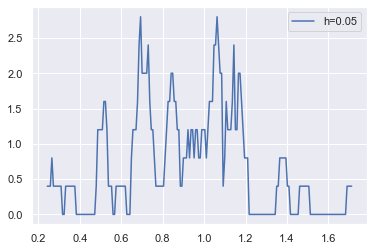

In [215]:
display_hypercube_kernel_density_1D(data_1D, 0.05, 'b')

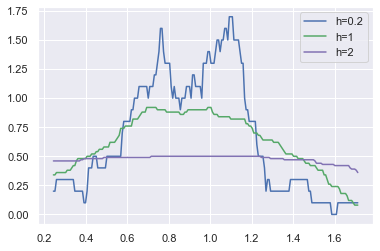

In [216]:
display_hypercube_kernel_density_1D(data_1D, 0.2, 'b')
display_hypercube_kernel_density_1D(data_1D, 1, 'g')
display_hypercube_kernel_density_1D(data_1D, 2, 'm')

### 2.2) Gaussian Kernel function

`gaussian_kernel_function` takes pair of points `x` and `x_n`, size `h` and returns Gaussian kernel function for this pair of points

In [217]:
from cmath import exp, pi

def gaussian_kernel_function(x, x_n, h):
    result = exp(-abs(x - x_n)**2 / (2 * h**2)) / ((2 * pi * h**2)**0.5)
    return result

`gaussian_kernel_density` takes any point `x`, data points `data`, size `h` and returns Gaussian kernel density for point `x`

In [218]:
def gaussian_kernel_density(x, data, h):
    result = sum(
        gaussian_kernel_function(x, x_n, h)
        for x_n in data
    ) / len(data)
    return result

In [219]:
def display_gaussian_kernel_density_1D(data, h, color='b'):
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, list(map(lambda x: gaussian_kernel_density(x, data, h), xs)), '-' + color, label='h=' + str(h))
    plt.legend()

c:\Users\jonas\miniconda3\envs\slml\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\jonas\miniconda3\envs\slml\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\jonas\miniconda3\envs\slml\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


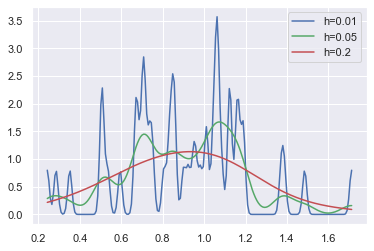

In [220]:
display_gaussian_kernel_density_1D(data_1D, 0.01, 'b')
display_gaussian_kernel_density_1D(data_1D, 0.05, 'g')
display_gaussian_kernel_density_1D(data_1D, 0.2, 'r')

## 3) K-Nearest Neigbours classification

### 3.1) Generate Data

(<matplotlib.collections.PathCollection at 0x1ce5a5f4d08>,
 <matplotlib.legend.Legend at 0x1ce5aa525c8>)

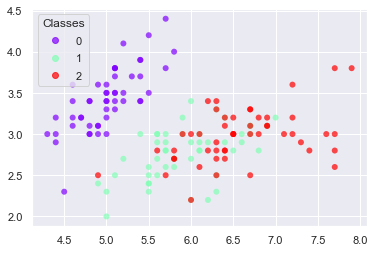

In [221]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

### 3.2) Classification function

`k_nearest_classification` takes any point `x`, data point positions `data_x`, their classes `data_t`, amount of neighbours `k` and returns class for the point `x`

In [222]:
from collections import Counter

def k_nearest_classification(x, data_x, data_t, k):
    assert(len(data_x) == len(data_t))

    data = [
        (
            x_n[0], x_n[1], t_n, sqrt((x_n[0] - x[0])**2 + (x_n[1] - x[1])**2)
        )
        for x_n, t_n in zip(data_x, data_t)
    ]
    data_by_dist = sorted(data, key=lambda x: x[3], reverse=False)
    k_closest_data = [
        data_by_dist[n]
        for n in range(k)
    ]
    t_counts = Counter(x_[2] for x_ in k_closest_data)
    result = t_counts.most_common(1)[0][0]

    return result

### 3.3) Display results

In [223]:
def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

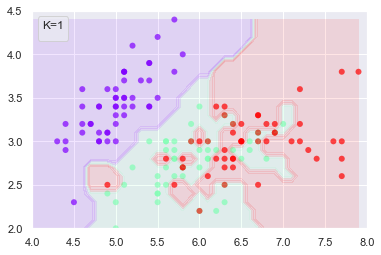

In [224]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 1))
plt.legend([], loc="upper left", title="K=1")

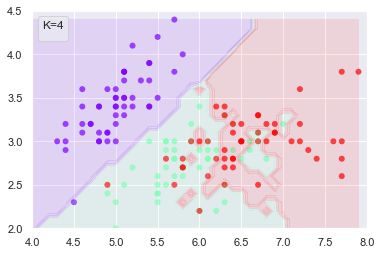

In [225]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 4))
plt.legend([], loc="upper left", title="K=4")

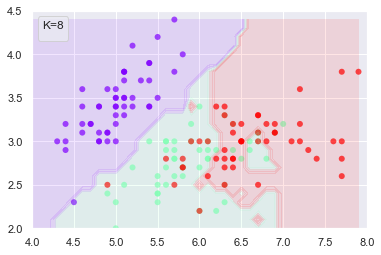

In [226]:
plot_iris(False)
plot_mesh(lambda x: k_nearest_classification(x, iris_x, iris_t, 8))
plt.legend([], loc="upper left", title="K=8")

## 4) K-Means clustering

`k_means_step` takes initial means `mus_0`, data points `data_x` and returns new means `mus` and `classes`

In [227]:
def k_means_step(mus_0, data_x):
    # learning rate parameter, determines the rate at which new means change per step
    eta = 0.003

    mus = mus_0
    classes = []

    for x in data_x:
        min_dist_mu = mus_0[0]
        min_dist = sqrt((mus_0[0][0] - x[0])**2 + (mus_0[0][1] - x[1])**2)
        k_closest = 0

        for k in range(1, len(mus_0)):
            dist = sqrt((mus_0[k][0] - x[0])**2 + (mus_0[k][1] - x[1])**2)
            if dist < min_dist:
                min_dist = dist
                k_closest = k
        
        mus_old = mus[k_closest]
        mus[k_closest] = mus_old + eta * (x - mus_old)
        classes.append(k_closest)
    
    return mus, classes
    

`distortion_measure` takes means `mus`, `classes`, data points `data_x` and returns distortion of this classification

In [228]:
def distortion_measure(mus, classes, data_x):
    
    result = 0
    
    for i, c in enumerate(classes):
        
        x = data_x[i]
        mu = mus[c]
        distance = np.dot(np.array(mu) - np.array(x), np.array(mu) - np.array(x))
        result += distance
    
    return result

`optimize_k_means` takes initial means `mus_0`, data points `data_x` and callback `on_step`

`on_step` is a function that takes current `mus` and `classes` and should be called each step 

In [229]:
def optimize_k_means(mus_0, data_x, on_step):

    mus, classes = k_means_step(mus_0, data_x)
    old_J = distortion_measure(mus, classes, data_x)
    on_step(mus, classes)
    mus, classes = k_means_step(mus, data_x)
    J = distortion_measure(mus, classes, data_x)
    on_step(mus, classes)

    i = 0
    while abs(J - old_J) > 0.001 and i < 80:
        old_J = J
        mus, classes = k_means_step(mus, data_x)
        J = distortion_measure(mus, classes, data_x)
        on_step(mus, classes)

### 4.1) Display results

In [230]:
def plot_k_means(mus, classes, target=plt):
    plot = plot_iris(classes=classes, target=target)
    scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='X', s=300, edgecolors='black')
    return (*plot, scatter)

In [231]:
k = 3
mus_0 = iris_x[:k]

all_steps = []

optimize_k_means(mus_0, iris_x, lambda mus, classes: all_steps.append((mus, classes)))

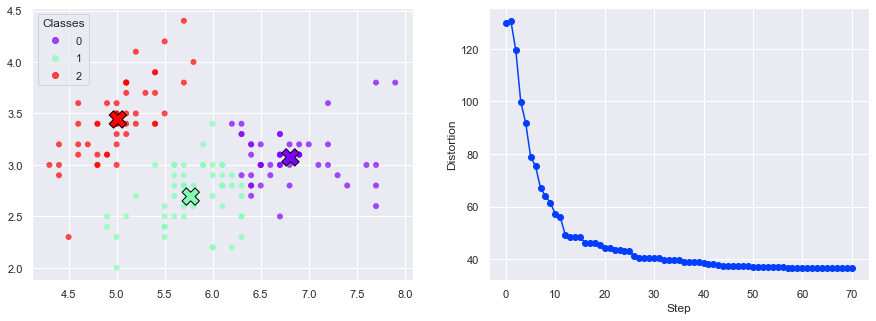

In [232]:
def create_animation(all_steps, data_x):
    
    distortions = list(map(
        lambda a: distortion_measure(a[0], a[1], data_x),
        all_steps
    ))
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        plot1 = plot_k_means(all_steps[i][0], all_steps[i][1], target=ax)
        ax2.plot(list(range(i)), distortions[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Distortion')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps, iris_x)